# Task 1: Data Understanding \& Preparation

In [499]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [500]:
import warnings 

warnings.filterwarnings('ignore')

## Loading the dataset

In [501]:
df = pd.read_csv('../dataset/customer_supermarket.csv', sep='\t', index_col=0)
df

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,01/12/10 08:26,"2,55",17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,01/12/10 08:26,"2,75",17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541905,581587,09/12/11 12:50,"2,1",12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,09/12/11 12:50,"4,15",12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,09/12/11 12:50,"4,15",12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4
541908,581587,09/12/11 12:50,"4,95",12680.0,France,22138,BAKING SET 9 PIECE RETROSPOT,3


## Basic checks

In [502]:
n_samples = df.shape[0]
df.drop_duplicates(ignore_index=True, inplace=True)
duplicates = n_samples - df.shape[0]
print('Number of canceled duplicates: {}/{} ({:.2f}%)'.format(duplicates, n_samples, duplicates / n_samples * 100))

Number of canceled duplicates: 5232/471910 (1.11%)


In [503]:
df.dtypes

BasketID            object
BasketDate          object
Sale                object
CustomerID         float64
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

In [504]:
df['Sale'] = df['Sale'].str.replace(',', '.')
df['Sale'] = pd.to_numeric(df['Sale'])
df = df.astype({'BasketDate': 'datetime64',
                'CustomerID': 'object'})

In [505]:
df.dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 object
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

This dataset contains 8 variables that correspond to:

- *BasketID*: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation;
- *BasketDate*: Invice Date and time. Numeric, the day and time when each transaction was generated;
- *Sale*: Unit price. Numeric, Product price per unit in sterling;
- *CustomerID*: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer;
- *CustomerCountry*: Country name. Nominal, the name of the country where each customer resides;
- *ProdID*: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product;
- *ProdDescr*: Product (item) name. Nominal;
- *Qta*: The quantities of each product (item) per transaction. Numeric.

In [506]:
df.isnull().sum()

BasketID               0
BasketDate             0
Sale                   0
CustomerID         65073
CustomerCountry        0
ProdID                 0
ProdDescr            753
Qta                    0
dtype: int64

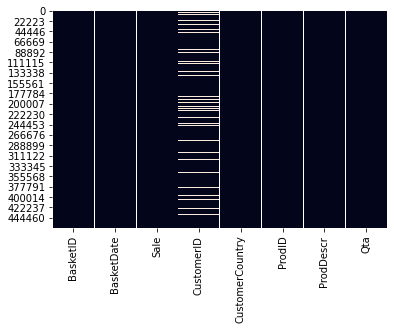

In [507]:
sns.heatmap(df.isnull(), cbar=False);

In [508]:
df.describe()

,Sale,Qta
count,466678.000000,466678.000000
mean,4.049057,10.806528
std,84.237135,232.627771
min,-11062.060000,-80995.000000
25%,1.250000,2.000000
50%,2.080000,4.000000
75%,3.750000,12.000000
max,38970.000000,80995.000000


## Data Cleaning and Integration

### Customer IDs

First of all, we are going to remove the entries for which the *CustomerID* variable is null:

In [509]:
df = df[~df['CustomerID'].isnull()]
df.reset_index(drop=True, inplace=True)
df['CustomerID'].isnull().any()

False

### Product IDs

Above, it has been seen that some values of the *ProdID* variable indicate a particular transaction (i.e., *D* for *Discount*). We check the contents of this variable by looking for the set of codes that would contain only letters:

In [510]:
special_codes = df[df['ProdID'].str.contains('^[a-zA-Z]+', regex=True)]['ProdID'].unique()
for code in special_codes:
    print("{:<15} -> {:<30}".format(code, df[df['ProdID'] == code]['ProdDescr'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


We see that there are several types of peculiar transactions, connected e.g., to *port charges* or *bank charges*.

In [511]:
df = df[~df.ProdID.isin(special_codes)]
df.reset_index(drop=True, inplace=True)
df.ProdID.isin(special_codes).any()

False

### Basket IDs

Then, we examined the existence of entries with the prefix *C* for the *BasketID* variable which indicates transactions that have been canceled since for each of those correspond a negative quantity:

In [512]:
cancelled_orders = df[df['BasketID'].str.contains('C')]
cancelled_orders

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
152,C536383,2010-01-12 09:49:00,4.65,15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
233,C536391,2010-01-12 10:24:00,1.65,17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
234,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
235,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24
236,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21980,PACK OF 12 RED RETROSPOT TISSUES,-24
...,...,...,...,...,...,...,...,...
399249,C581490,2011-09-12 09:57:00,1.95,14397,United Kingdom,22178,VICTORIAN GLASS HANGING T-LIGHT,-12
399250,C581490,2011-09-12 09:57:00,0.83,14397,United Kingdom,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11
399498,C581568,2011-09-12 11:57:00,10.95,15311,United Kingdom,21258,VICTORIAN SEWING BOX LARGE,-5
399499,C581569,2011-09-12 11:58:00,1.25,17315,United Kingdom,84978,HANGING HEART JAR T-LIGHT HOLDER,-1


In [513]:
(cancelled_orders['Qta'] < 0).all()

True

In [514]:
df[df['Sale'] == 0]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
6816,537197,2010-05-12 14:02:00,0.0,12647,Germany,22841,ROUND CAKE TIN VINTAGE GREEN,1
22536,539263,2010-12-16 14:36:00,0.0,16560,United Kingdom,22580,ADVENT CALENDAR GINGHAM SACK,4
25442,539722,2010-12-21 13:45:00,0.0,14911,EIRE,22423,REGENCY CAKESTAND 3 TIER,10
29243,540372,2011-06-01 16:41:00,0.0,13081,United Kingdom,22090,PAPER BUNTING RETROSPOT,24
29245,540372,2011-06-01 16:41:00,0.0,13081,United Kingdom,22553,PLASTERS IN TIN SKULLS,24
34743,541109,2011-01-13 15:10:00,0.0,15107,United Kingdom,22168,ORGANISER WOOD ANTIQUE WHITE,1
54228,543599,2011-10-02 13:08:00,0.0,17560,United Kingdom,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16
86338,547417,2011-03-23 10:25:00,0.0,13239,United Kingdom,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36
93491,548318,2011-03-30 12:45:00,0.0,13113,United Kingdom,22055,MINI CAKE STAND HANGING STRAWBERY,5
98139,548871,2011-04-04 14:42:00,0.0,14410,United Kingdom,22162,HEART GARLAND RUSTIC PADDED,2


In [515]:
df['Sale'].replace(0, np.nan, inplace=True)
df['Sale'] = df.groupby('ProdID')['Sale'].transform(lambda x: x.replace(to_replace=np.nan, value=x.mean()))
df['Sale'].isnull().any()

False

In [516]:
df['TotSale'] = df['Qta'] * df['Sale']
df

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,TotSale
0,536365,2010-01-12 08:26:00,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,15.30
1,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6,20.34
2,536365,2010-01-12 08:26:00,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8,22.00
3,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,20.34
4,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,20.34
...,...,...,...,...,...,...,...,...,...
399684,581587,2011-09-12 12:50:00,0.85,12680,France,22613,PACK OF 20 SPACEBOY NAPKINS,12,10.20
399685,581587,2011-09-12 12:50:00,2.10,12680,France,22899,CHILDREN'S APRON DOLLY GIRL,6,12.60
399686,581587,2011-09-12 12:50:00,4.15,12680,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4,16.60
399687,581587,2011-09-12 12:50:00,4.15,12680,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,16.60


In [517]:
monetary = df.groupby('CustomerID', as_index=False)['TotSale'].sum()
monetary.columns = ['CustomerID', 'Monetary']
zero_monetary = monetary[monetary['Monetary'] == 0]
zero_monetary

,CustomerID,Monetary
0,12346.0,0.0
1639,14557.0,0.0
1806,14792.0,0.0
3343,16878.0,0.0
4349,18268.0,0.0


In [518]:
df = df[~df.CustomerID.isin(zero_monetary.index)]
df.reset_index(drop=True, inplace=True)
df.CustomerID.isin(zero_monetary.index).any()

False

In [519]:
df = df[~df['BasketID'].str.contains('C')]
df.reset_index(drop=True, inplace=True)
df['BasketID'].str.contains('C').any()

False

### Customers Country

In [520]:
df['CustomerCountry'].value_counts()

United Kingdom          348892
Germany                   8644
France                    8019
EIRE                      7128
Spain                     2418
Netherlands               2326
Belgium                   1935
Switzerland               1811
Portugal                  1416
Australia                 1183
Norway                    1049
Channel Islands            743
Italy                      741
Finland                    647
Cyprus                     601
Sweden                     427
Austria                    384
Denmark                    367
Poland                     325
Japan                      321
Israel                     245
Unspecified                241
Singapore                  215
Iceland                    182
USA                        179
Canada                     150
Greece                     142
Malta                      109
United Arab Emirates        67
RSA                         57
European Community          57
Lebanon                     45
Lithuani

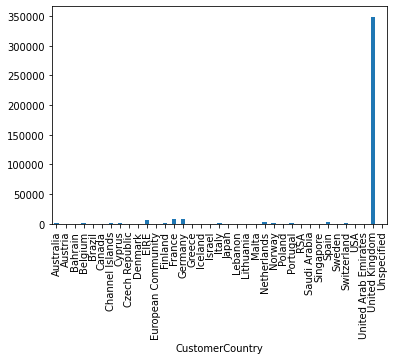

In [521]:
df['CustomerCountry'].groupby(df['CustomerCountry']).count().plot(kind='bar');

As customer clusters may vary by geography, we’ll restrict the data to only United Kingdom customers, which contains most of our customers historical data.

In [522]:
df = df[df['CustomerCountry'] == 'United Kingdom']
df.reset_index(drop=True, inplace=True)
(df['CustomerCountry'] != 'United Kingdom').any()

False

In [523]:
df.drop('CustomerCountry', axis=1, inplace=True)

### Baskets Date

We noticed that 2010 data aren't enough representative, they are only a small fraction of the dataset and they appear to be only around the 12th of the month; in contrast 2011's data are more uniformely distributed, so we decide to keep only the latter:

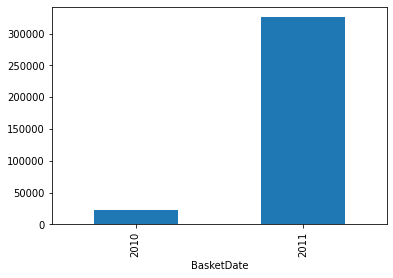

In [524]:
df['BasketDate'].groupby(df['BasketDate'].dt.year).count().plot(kind='bar');

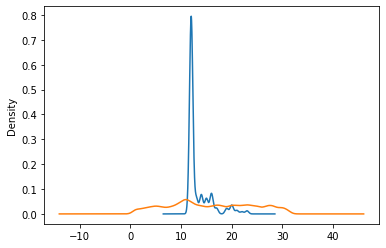

In [525]:
fig, ax = plt.subplots(1,1)
df[df['BasketDate'].dt.year == 2010]['BasketDate'].dt.day.plot(kind='kde', ax=ax);
df[df['BasketDate'].dt.year == 2011]['BasketDate'].dt.day.plot(kind='kde', ax=ax);

In [526]:
df = df[df['BasketDate'].dt.year == 2011]
df.reset_index(drop=True, inplace=True)
(df['BasketDate'].dt.year == 2010).any()

False

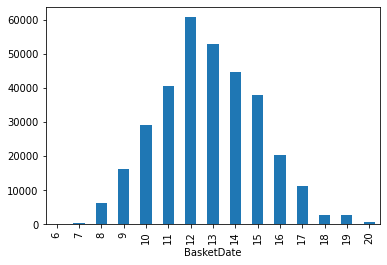

In [527]:
df['BasketDate'].groupby(df['BasketDate'].dt.hour).count().plot(kind='bar');

### Sales

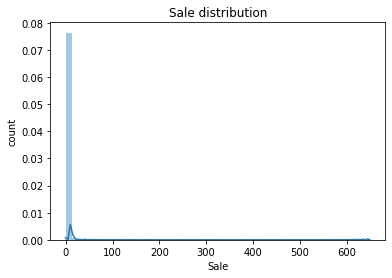

In [528]:
sns.distplot(df['Sale'])
plt.title('Sale distribution')
plt.xlabel('Sale')
plt.ylabel('count');

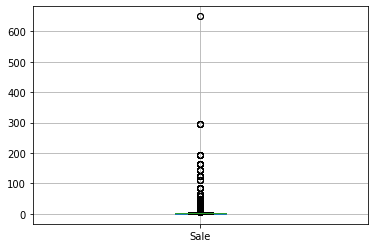

In [529]:
df.boxplot('Sale');

We can use the interquartile range method to reduce the outliers and distribution skewness:

- IQR = Q3 - Q1
- lower bound = Q1 - 1.5 * IQR
- upper bound = Q3 + 1.5 * IQR

In [530]:
q1 = df['Sale'].quantile(0.25)
q3 = df['Sale'].quantile(0.75)
iqr = q3 - q1 
lb = q1 - 1.5 * iqr
ub = q3 + 1.5 * iqr

print('Q1 = {}'.format(q1))
print('Q3 = {}'.format(q3))
print('IQR = Q3 - Q1 = {}'.format(iqr))
print('lower bound = Q1 - 1.5 * IQR = {}'.format(lb))
print('upper bound = Q1 - 1.5 * IQR = {}'.format(ub))

Q1 = 1.25
Q3 = 3.75
IQR = Q3 - Q1 = 2.5
lower bound = Q1 - 1.5 * IQR = -2.5
upper bound = Q1 - 1.5 * IQR = 7.5


In [531]:
df = df[~((df['Sale'] < lb) | (df['Sale'] > ub))]
df

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta,TotSale
0,539993,2011-04-01 10:00:00,1.95,13313,22386,JUMBO BAG PINK POLKADOT,10,19.5
1,539993,2011-04-01 10:00:00,0.42,13313,21499,BLUE POLKADOT WRAP,25,10.5
2,539993,2011-04-01 10:00:00,0.42,13313,21498,RED RETROSPOT WRAP,25,10.5
3,539993,2011-04-01 10:00:00,2.10,13313,22379,RECYCLING BAG RETROSPOT,5,10.5
4,539993,2011-04-01 10:00:00,1.25,13313,20718,RED RETROSPOT SHOPPER BAG,10,12.5
...,...,...,...,...,...,...,...,...
325457,581585,2011-09-12 12:31:00,0.95,15804,23145,ZINC T-LIGHT HOLDER STAR LARGE,12,11.4
325458,581585,2011-09-12 12:31:00,1.95,15804,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,23.4
325459,581586,2011-09-12 12:49:00,2.95,13113,22061,LARGE CAKE STAND HANGING STRAWBERY,8,23.6
325460,581586,2011-09-12 12:49:00,1.25,13113,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,30.0


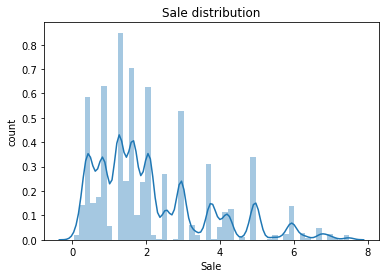

In [532]:
sns.distplot(df['Sale'])
plt.title('Sale distribution')
plt.xlabel('Sale')
plt.ylabel('count');

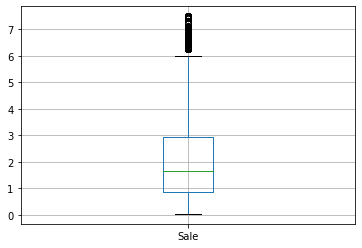

In [533]:
df.boxplot('Sale');

### Quantities

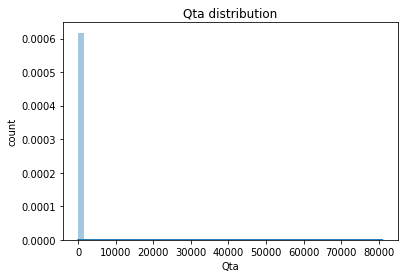

In [534]:
sns.distplot(df['Qta'])
plt.title('Qta distribution')
plt.xlabel('Qta')
plt.ylabel('count');

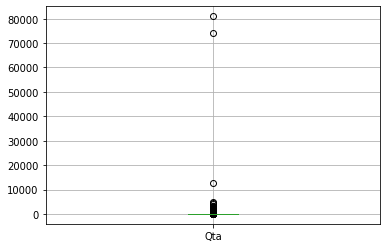

In [535]:
df.boxplot('Qta');

Also, we notice the presence of some negative quantities which can be considered as a canceled orders or refund:

We can use the interquartile range method to reduce the outliers and distribution skewness:

- IQR = Q3 - Q1
- lower bound = Q1 - 1.5 * IQR
- upper bound = Q3 + 1.5 * IQR

In [536]:
q1 = df['Qta'].quantile(0.25)
q3 = df['Qta'].quantile(0.75)
iqr = q3 - q1
lb = q1 - 1.5 * iqr
ub = q3 + 1.5 * iqr

print('Q1 = {}'.format(q1))
print('Q3 = {}'.format(q3))
print('IQR = Q3 - Q1 = {}'.format(iqr))
print('lower bound = Q1 - 1.5 * IQR = {}'.format(lb))
print('upper bound = Q3 + 1.5 * IQR = {}'.format(ub))

Q1 = 2.0
Q3 = 12.0
IQR = Q3 - Q1 = 10.0
lower bound = Q1 - 1.5 * IQR = -13.0
upper bound = Q3 + 1.5 * IQR = 27.0


In [537]:
df = df[~((df['Qta'] < lb) | (df['Qta'] > ub))]
df

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta,TotSale
0,539993,2011-04-01 10:00:00,1.95,13313,22386,JUMBO BAG PINK POLKADOT,10,19.5
1,539993,2011-04-01 10:00:00,0.42,13313,21499,BLUE POLKADOT WRAP,25,10.5
2,539993,2011-04-01 10:00:00,0.42,13313,21498,RED RETROSPOT WRAP,25,10.5
3,539993,2011-04-01 10:00:00,2.10,13313,22379,RECYCLING BAG RETROSPOT,5,10.5
4,539993,2011-04-01 10:00:00,1.25,13313,20718,RED RETROSPOT SHOPPER BAG,10,12.5
...,...,...,...,...,...,...,...,...
325457,581585,2011-09-12 12:31:00,0.95,15804,23145,ZINC T-LIGHT HOLDER STAR LARGE,12,11.4
325458,581585,2011-09-12 12:31:00,1.95,15804,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,23.4
325459,581586,2011-09-12 12:49:00,2.95,13113,22061,LARGE CAKE STAND HANGING STRAWBERY,8,23.6
325460,581586,2011-09-12 12:49:00,1.25,13113,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,30.0


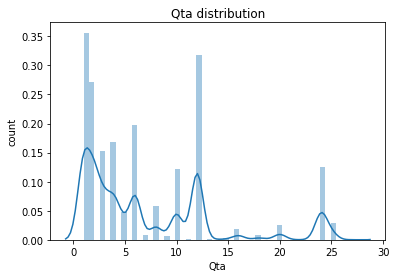

In [538]:
sns.distplot(df['Qta'])
plt.title('Qta distribution')
plt.xlabel('Qta')
plt.ylabel('count');

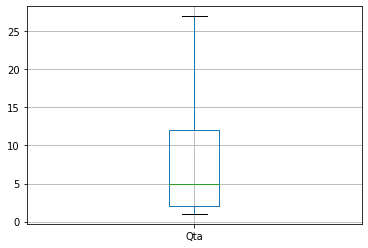

In [539]:
df.boxplot('Qta');

### Products Description

In [540]:
df['ProdDescr'].isnull().any()

False

Now we need to remove the entries corresponding to lower or mixed case *ProdDescr* variable which will be not effective for the feature extraction step since they don't represent a product description:

In [541]:
df[(df['ProdDescr'].str.islower()) | # lower case
   (~df['ProdDescr'].str.islower() & ~df['ProdDescr'].str.isupper())]['ProdDescr'].unique() # mixed case

array(['BAG 125g SWIRLY MARBLES', 'BAG 500g SWIRLY MARBLES',
       '3 TRADITIONAl BISCUIT CUTTERS  SET',
       'FRENCH BLUE METAL DOOR SIGN No', 'NUMBER TILE VINTAGE FONT No ',
       'BAG 250g SWIRLY MARBLES', 'POLYESTER FILLER PAD 40x40cm',
       'POLYESTER FILLER PAD 45x45cm', 'FOLK ART GREETING CARD,pack/12',
       'POLYESTER FILLER PAD 45x30cm', 'POLYESTER FILLER PAD 30CMx30CM',
       'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
       'NUMBER TILE COTTAGE GARDEN No', 'POLYESTER FILLER PAD 65CMx65CM',
       'POLYESTER FILLER PAD 60x40cm', 'FLOWERS HANDBAG blue and orange',
       'THE KING GIFT BAG 25x24x12cm', 'High Resolution Image'],
      dtype=object)

In [542]:
df['ProdDescr'] = df['ProdDescr'].str.replace('[^\w\s]', '') # removing non-word chars (+, -, /, etc.) but leaving spaces
df['ProdDescr'] = df['ProdDescr'].str.replace('[0-9]+[a-zA-Z]*', '') # removing words containing numbers

df['ProdDescr'] = df['ProdDescr'].apply(lambda descr: ' '.join(descr.split())) # removing multiple whitespaces

# adjusting specific errors
df['ProdDescr'] = df['ProdDescr'].str.replace('No', '') # removing 'No'
df['ProdDescr'].replace({'TRADITIONAl BISCUIT CUTTERS SET': 'TRADITIONAl BISCUIT CUTTERS SET'.upper()}, inplace=True)
df['ProdDescr'].replace({'FLOWERS HANDBAG blue and orange': 'FLOWERS HANDBAG blue and orange'.upper()}, inplace=True)
df['ProdDescr'].replace({'FOLK ART GREETING CARDpack': 'FOLK ART GREETING CARD'}, inplace=True)

bad_descr = df[(df['ProdDescr'].str.islower()) | # lower case
               (~df['ProdDescr'].str.islower() & ~df['ProdDescr'].str.isupper())]['ProdDescr'].unique() # mixed case
bad_descr

array(['High Resolution Image'], dtype=object)

In [543]:
df = df[~df['ProdDescr'].isin(bad_descr)]
df.reset_index(drop=True, inplace=True)
df['ProdDescr'].isin(bad_descr).any()

False

## Saving the new dataset

In [544]:
df.to_csv('../dataset/new_customer_supermarket.csv', sep='\t', float_format='%.2f')